In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/QROMP/")

 Activating environment at `/media/mat/HDD/QROMP/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using Statistics
using BenchmarkTools
using QROMP
using Permutations
using Test
using Plots

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


In [3]:
ψ = randn(10, 5)
u = randn(10)

10-element Array{Float64,1}:
 -0.6051348146359576
 -1.241153740897068
 -0.4597526092223104
 -0.9294996231796989
  1.1742337428346474
 -0.11244248923129455
  1.6652921177505111
 -0.068374450079629
 -1.0263228506517061
 -0.41585237222283494

In [38]:
ψ = randn(100, 20)
u = randn(100)
ctrue = ψ\u

20-element Array{Float64,1}:
  0.09465241057441921
  0.036703248984833244
 -0.16487549462026252
 -0.062442494110697806
  0.15999395960393734
  0.10645218175760116
 -0.02077279130389582
  0.07213787540171147
  0.09130212795875077
  0.09338601037119122
 -0.16386817925205702
 -0.15655315512604323
 -0.08678181234421962
  0.24344454654676412
 -0.06791209031101907
 -0.009808315025975798
  0.18671956793670835
  0.005484009414128153
 -0.01827862403882158
 -0.04901228672893078

In [39]:
# Force a greedy approach over the entire set of indices
# With LS
@time idxls, cls, ϵls = lsomp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With QR
@time idxqr, cqr, ϵqr, Fqr = qromp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With pivoted QR
idxpivot, cpivot, ϵpivot = pivotedqr(ψ, u; invert = true, verbose = true, ϵrel = eps())


# @test norm(idxls - idxqr)<1e-14
@test norm(ctrue[idxqr]-cqr)<1e-14
@test norm(ctrue[idxls]-cls)<1e-14
# @test norm(ϵls-ϵqr)<1e-14

  0.001264 seconds (1.95 k allocations: 1.864 MiB)
  0.000281 seconds (373 allocations: 1.486 MiB)


Test Passed

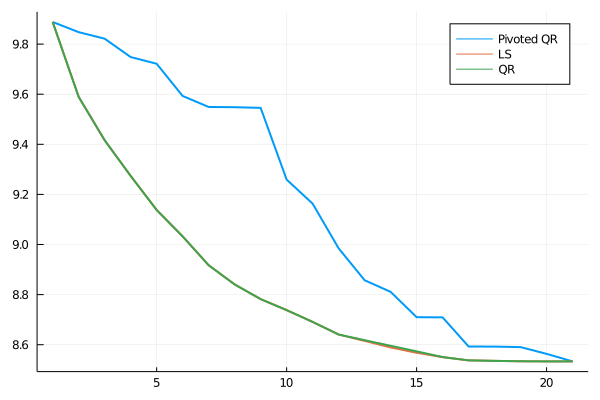

In [40]:
plot(ϵpivot, linewidth = 2, label = "Pivoted QR")
plot!(ϵls, linewidth = 2, label = "LS")
plot!(ϵqr, linewidth = 2, label = "QR")

In [27]:
Matrix(Fqr.Q)*ctrue

100-element Array{Float64,1}:
 -0.0413760373215651
  0.013346118010093055
 -0.014313835982187922
 -0.03942187288928408
 -0.00443483295381525
 -0.026305672994095648
 -0.00047586773202929616
  0.04066421088751999
 -0.023893367024550995
  0.035225725062114126
 -0.01932552585125332
  0.036753993057455615
  0.01029577111151621
  ⋮
  0.0365830092732118
 -0.03302085608967173
 -0.024606107333541564
  0.0071669463726614525
 -0.0469613260986224
 -0.028189472971779723
 -0.02393206188841015
  0.01798561772777293
  0.05205154612377666
 -0.05171391778684392
 -0.043021028503505254
  0.04592077309873513

In [28]:
Fqr.Q*ctrue

100-element Array{Float64,1}:
 -0.04137603732156514
  0.013346118010093073
 -0.014313835982187915
 -0.03942187288928408
 -0.004434832953815256
 -0.026305672994095627
 -0.0004758677320293328
  0.040664210887519994
 -0.023893367024550995
  0.035225725062114084
 -0.01932552585125332
  0.03675399305745566
  0.01029577111151622
  ⋮
  0.0365830092732118
 -0.033020856089671716
 -0.024606107333541568
  0.007166946372661457
 -0.04696132609862243
 -0.028189472971779712
 -0.023932061888410162
  0.017985617727772924
  0.052051546123776646
 -0.05171391778684393
 -0.04302102850350527
  0.04592077309873513

In [8]:
ϵqr-ϵls

21-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.0013671451430425918
  0.005954298459510454
  0.007672023017663676
  0.007495348235318389
  0.011447626534831556
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [89]:
idxls

20-element Array{Int64,1}:
 19
 12
 13
  1
  4
  7
  5
 16
  6
 20
 17
  3
 10
  9
  2
 15
 14
  8
 18
 11

In [84]:
ϵls - ϵqr

21-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.004262673807202688
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -8.881784197001252e-16
  0.0
  0.0
 -8.881784197001252e-16
  0.0
  0.0
  0.0
  0.0
 -8.881784197001252e-16
 -8.881784197001252e-16

In [18]:
ψ = randn(100, 20)
u = randn(100)
ctrue = ψ\u

# Force a greedy approach over the entire set of indices
# With LS
idxls, cls, ϵls = lsomp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# With QR
idxqr, cqr, ϵqr = qromp(ψ, u; invert = true, verbose = true, ϵrel = eps())

# @test norm(cls-cqr)<1e-14
# @test norm(idxls-idxqr)<1e-14
@test norm(ctrue[idxqr]-cls)<1e-14
@test norm(ctrue[idxqr]-cqr)<1e-14
@test norm(ϵls-ϵqr)<1e-14

Test Failed at In[18]:14
  Expression: norm(ctrue[idxqr] - cls) < 1.0e-14
   Evaluated: 0.008899886983870934 < 1.0e-14


LoadError: [91mThere was an error during testing[39m

In [63]:
ψ = randn(100, 20)
u = randn(100)
m, n = size(ψ)
ctrue = ψ\u

# Force a greedy approach over the entire set of indices
# With QR
idxqr, cqr, ϵqr = qromp(ψ, u; invert = true, verbose = true, ϵrel = eps())

@test norm(ctrue[idxqr]-cqr)<1e-14
# Residual error must decrease
@test all(ϵqr[2:end]-ϵqr[1:end-1] .< 0) == true

for k=1:n
    cverif = view(ψ,:, idxqr[1:k])\u
#     @show cverif
    @show norm(ϵqr[k+1] - norm(u - view(ψ,:, idxqr[1:k])*cverif))
end

norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 1.7763568394002505e-15
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 1.7763568394002505e-15
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 1.7763568394002505e-15
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 0.0
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * cverif)) = 1.7763568394002505e-15
norm(ϵqr[k + 1] - norm(u - view(ψ, :, idxqr[1:k]) * c

In [71]:
F = qr(ψ, Val(true));

In [78]:
typeof(typemax(Int64))<:Int64

true

LoadError: [91mUndefVarError: pivotedqr not defined[39m

In [56]:
b = randn(5)
@show norm(b)
v = deepcopy(b)
bcopy = deepcopy(b)
a = randn(5)

tau = deepcopy(LinearAlgebra.reflector!(v))

Hb = LinearAlgebra.reflectorApply!(v, tau, repeat(b, 1, 1))
@show Hb
@show norm(bcopy)
@show -norm(bcopy)*sign(bcopy[1])

#  What is the best way to apply the reflection to a vector a?
@show Ha = LinearAlgebra.reflectorApply!(v, tau, repeat(a,1,1));

norm(b) = 1.9799448125238643
Hb = [-1.9799448125238646; -5.551115123125783e-17; 2.220446049250313e-16; 2.220446049250313e-16; -2.220446049250313e-16]
norm(bcopy) = 1.9799448125238643
-(norm(bcopy)) * sign(bcopy[1]) = -1.9799448125238643
Ha = LinearAlgebra.reflectorApply!(v, tau, repeat(a, 1, 1)) = [-0.5062333940143671; -1.1850776857048684; -1.295711281614973; -0.16447887645751813; 1.065353231871041]


In [58]:
?setdiff!

search: setdiff! setdiff



```
setdiff!(s, itrs...)
```

Remove from set `s` (in-place) each element of each iterable from `itrs`. Maintain order with arrays.

# Examples

```jldoctest
julia> a = Set([1, 3, 4, 5]);

julia> setdiff!(a, 1:2:6);

julia> a
Set{Int64} with 1 element:
  4
```


In [ ]:
Sorry, my previous post was confusing.
My vector `x` is a simple `Array{Float64,1}`, 
But the function reflectorApply!(x::AbstractArray{T,1} where T, tau::Number, A::StridedArray{T, 2} where T) can only be applied to a 

```I am wondering if I could 

```
b = randn(5)
@show norm(b)
v = deepcopy(b)
bcopy = deepcopy(b)
x = randn(5)

tau = deepcopy(LinearAlgebra.reflector!(v))

Hb = LinearAlgebra.reflectorApply!(v, tau, repeat(b, 1, 1))

@show Hb
@show norm(bcopy)
@show -norm(bcopy)*sign(bcopy[1])
```

In [51]:
?LinearAlgebra.reflectorApply!

No documentation found.

`LinearAlgebra.reflectorApply!` is a `Function`.

```
# 1 method for generic function "reflectorApply!":
[1] reflectorApply!(x::AbstractArray{T,1} where T, τ::Number, A::StridedArray{T, 2} where T) in LinearAlgebra at /home/mat/julia-1.5.3/share/julia/stdlib/v1.5/LinearAlgebra/src/generic.jl:1491
```


In [50]:
x

5-element Array{Float64,1}:
  0.776618555571962
  0.6271970365740471
 -0.1343712318446769
  1.0622648539045827
 -0.30877685538559524

In [45]:
idxls

20-element Array{Int64,1}:
 19
  2
  7
  9
 10
  5
  4
 17
 12
  3
 15
 11
  1
 16
 14
 20
 18
  6
 13
  8

In [14]:
ψ = randn(100, 20)
u = randn(100)
ctrue = ψ\u

# Force a greedy approach over the entire set of indices
idxqr, cqr, ϵqr = qromp(ψ, u; invert = true, verbose = true, ϵrel = eps())

ctrue[idxqr]-cqr

20-element Array{Float64,1}:
 -5.551115123125783e-17
 -1.3877787807814457e-16
 -2.7755575615628914e-17
  2.7755575615628914e-17
 -1.6653345369377348e-16
  5.551115123125783e-17
 -2.7755575615628914e-17
 -8.326672684688674e-17
  4.163336342344337e-17
 -1.3877787807814457e-17
 -6.938893903907228e-18
 -8.326672684688674e-17
 -6.938893903907228e-17
  8.326672684688674e-17
 -1.0061396160665481e-16
 -6.938893903907228e-17
 -1.1796119636642288e-16
  4.5102810375396984e-17
 -1.0408340855860843e-17
 -1.4137996329210978e-16

In [15]:
idxls, cls, ϵls = lsomp(ψ, u; invert = true, verbose = true, ϵrel = eps())

([9, 3, 7, 13, 4, 8, 1, 12, 10, 16, 6, 18, 14, 17, 11, 15, 19, 5, 2, 20], [-0.2506031321682384, -0.17392465273137098, -0.24079069218219784, 0.1090935494748859, 0.1322076048782769, 0.08524198089485648, -0.12748152062999413, 0.1094803749688049, -0.08491440849332767, -0.07576788691807354, -0.0393658837488793, 0.05466428348600987, 0.041113779647310916, -0.04243453276950227, 0.01874583892979714, -0.016489640266223463, -0.016328992116068003, -0.006345061296298244, 0.006422478411347741, 0.0026470111389088526], [11.009443765722283, 10.685684644659238, 10.563824341124722, 10.426618492141978, 10.360319592126793, 10.301090719005163, 10.256650224501296, 10.209523032492013, 10.17096318539637, 10.141242516926429  …  10.100454908053017, 10.091727436009046, 10.083648792362249, 10.07704364217177, 10.075346267784203, 10.074422353123964, 10.073541304729138, 10.073373076781115, 10.073259812539547, 10.073230626050668])

In [21]:
cls-cqr

20-element Array{Float64,1}:
 -1.1102230246251565e-16
 -1.3877787807814457e-16
  2.7755575615628914e-17
 -0.023114055403390996
  0.02311405540339083
 -0.02423839407394837
 -5.551115123125783e-17
  0.024238394073948427
  0.0
 -2.7755575615628914e-17
 -6.938893903907228e-18
 -1.0408340855860843e-16
 -7.632783294297951e-17
  9.020562075079397e-17
 -9.367506770274758e-17
 -1.3183898417423734e-16
 -9.020562075079397e-17
  8.673617379884035e-18
 -2.3332030751888055e-16
 -1.5308934675495323e-16

In [25]:
ctrue[idxqr]-cqr
ctrue[idxls]-cls

20-element Array{Float64,1}:
  5.551115123125783e-17
  0.0
 -5.551115123125783e-17
  0.0
  2.7755575615628914e-17
 -8.326672684688674e-17
  2.7755575615628914e-17
  0.0
  4.163336342344337e-17
  1.3877787807814457e-17
  0.0
  2.0816681711721685e-17
  6.938893903907228e-18
 -6.938893903907228e-18
 -6.938893903907228e-18
  6.245004513516506e-17
 -2.7755575615628914e-17
  3.642919299551295e-17
  2.229119666630197e-16
  1.1709383462843448e-17

In [110]:
FOMP.Q*FOMP.R*P'-ψ

10×5 Array{Float64,2}:
 -1.38778e-17   2.22045e-16   4.44089e-16  -1.11022e-16  -4.44089e-16
  0.0           0.0          -2.22045e-16   0.0          -2.22045e-16
 -2.22045e-16   0.0           2.22045e-16   2.77556e-17   0.0
 -4.44089e-16   0.0          -2.22045e-16   0.0           0.0
  0.0           0.0           0.0           0.0          -2.22045e-16
  1.11022e-16   0.0           0.0           5.55112e-17  -1.11022e-16
 -2.22045e-16  -1.11022e-16   1.11022e-16   0.0           0.0
  0.0           0.0           0.0           5.55112e-17   5.55112e-17
  0.0           0.0           0.0           0.0           5.55112e-17
  0.0           0.0           5.55112e-17   0.0          -1.11022e-16

In [74]:
## Orthogonal Matching Pursuit
idx_OMP = Int64[]
ϵ = 1e-1
res_OMP = deepcopy(u)
Γ_OMP = Float64[]
dict_OMP = collect(1:n);
entry = 0.0;
counter = 0
new_idx = 1

normcol = norm.(eachcol(ψ))
@show normcol
c_OMP = zero(ψ\u)

@inbounds while counter < size(ψ,2) #&& norm(res_OMP)>ϵ
    counter += 1
    # Compute 
    entry = 0.0

    for (i, idx) in enumerate(dict_OMP)
        col = view(ψ,:,idx)
        ratio = (dot(col,res_OMP)/normcol[idx])^2
        # Find the largest entry and its index on the fly
        if ratio > entry
            entry = ratio
            new_idx = idx
        end
    end
    @show entry, new_idx
    filter!(x-> x != new_idx, dict_OMP)
    push!(idx_OMP, copy(new_idx))
#     @assert sort(union(idx_OMP, dict_OMP)) == collect(1:nblob)
    ψ_OMP = view(ψ,:,sort(idx_OMP))
    c_OMP = ψ_OMP\u
    res_OMP = u-ψ_OMP*c_OMP
    @show norm(res_OMP)/norm(u)
end

normcol = [2.295229894632921, 3.8577630786296475, 2.1570039960723766, 5.01183467379606, 2.944282239584703]
(entry, new_idx) = (5.290084514515703, 1)
norm(res_OMP) / norm(u) = 0.8074598006228048
(entry, new_idx) = (3.110374459725085, 3)
norm(res_OMP) / norm(u) = 0.6656023726192064
(entry, new_idx) = (1.6242063603795405, 4)
norm(res_OMP) / norm(u) = 0.5759683159681794
(entry, new_idx) = (1.0246926350150303, 2)
norm(res_OMP) / norm(u) = 0.4906497491286512
(entry, new_idx) = (0.044705391291883306, 5)
norm(res_OMP) / norm(u) = 0.48499593629880516


In [75]:
c_OMP

5-element Array{Float64,1}:
 -0.9870716766793397
  0.385696490747567
 -0.3994939702253127
 -0.3342135128920916
  0.13469352291508357

In [76]:
cLS

5-element Array{Float64,1}:
 -0.9870716766793397
  0.385696490747567
 -0.3994939702253127
 -0.3342135128920916
  0.13469352291508357

In [35]:
Matrix(F.Q)*Matrix(F.Q)'

100×100 Array{Float64,2}:
  0.109049      0.0121885    -0.0247129   …   0.0528155    0.0340403
  0.0121885     0.0834409     0.0120749       0.0337248    0.0107088
 -0.0247129     0.0120749     0.11785         0.00792615  -0.0205
 -0.0265195    -0.0176442     0.0559337      -0.00618252  -0.104716
  1.3746e-5     0.0421841     0.0546239       0.0373985    0.0932801
  0.0336775    -0.0062833    -0.079351    …  -0.0247392    0.0279264
  0.0555426    -0.00431462   -0.0141412       0.0145937    0.0471913
  0.0400674     0.00612087   -0.0226838       0.0203272   -0.0702643
  0.0182465    -0.0171899     0.0323537      -0.0153783    0.0141202
 -0.00458054    0.0328571     0.0507023      -0.0111118   -0.0374159
  0.00219689   -0.00106086    0.0097368   …   0.0209563    0.0111246
  0.0445891    -0.0022222     0.0288602       0.00490472   0.0383929
  0.0224388    -0.00176537   -0.0535356      -0.00801796   0.0413919
  ⋮                                       ⋱               
 -0.0214373     0.0052

In [30]:
ψ*c-u;

In [15]:
?normsqu

search: UniformScaling set_zero_subnormals get_zero_subnormals

Couldn't find normsqu
Perhaps you meant norm or normpath


No documentation found.

Binding `normsqu` does not exist.


In [29]:
(Matrix(F.Q)[:,1:9]*Matrix(F.Q)[:,1:9]' + Matrix(F.Q)[:,10]*Matrix(F.Q)[:,10]' - I)*u

100-element Array{Float64,1}:
  0.3758311589958424
  1.0585258076048505
  0.4447818407388319
  0.008553486267878399
  0.5800017631473279
  3.188412904859621
 -0.429577451836499
  0.208439956957505
 -0.08090965585245928
 -0.6038900950214523
  1.329789864255415
 -0.4949821463908698
 -0.7068285764729044
  ⋮
  0.044066172301584106
  1.0246146496589115
  0.1878612517179839
 -0.4173313397315703
  0.8272517442787691
  2.206261988756783
  0.34520276399716154
 -0.23646085941167977
  0.7055617064816128
  0.7709500107352945
 -2.4601768968417264
  0.34420330677473154

In [25]:
Matrix(F.Q)'*u

10-element Array{Float64,1}:
 -3.090247135269122
 -1.6048265352544309
  0.03897833173484622
 -0.5814289181053852
 -0.7094619236376158
 -1.8678473043938453
  0.10922273046087827
  0.026014165881648843
  1.1469596769660972
 -0.20439148335509472

In [19]:
(Matrix(F.Q)*Matrix(F.Q)'-I)*u

100-element Array{Float64,1}:
  0.3758311589958424
  1.0585258076048505
  0.4447818407388319
  0.008553486267878371
  0.5800017631473279
  3.188412904859621
 -0.429577451836499
  0.208439956957505
 -0.08090965585245928
 -0.6038900950214522
  1.329789864255415
 -0.4949821463908697
 -0.7068285764729044
  ⋮
  0.044066172301584106
  1.0246146496589115
  0.1878612517179839
 -0.4173313397315703
  0.8272517442787691
  2.2062619887567827
  0.3452027639971615
 -0.23646085941167988
  0.7055617064816128
  0.7709500107352945
 -2.4601768968417264
  0.34420330677473154

In [18]:
Matrix(F.Q)'*Matrix(F.Q)

10×10 Array{Float64,2}:
  1.0          -2.97047e-18   1.36488e-17  …   3.5366e-17   -7.8012e-18
 -2.97047e-18   1.0          -6.15815e-18     -6.53399e-17   3.4025e-17
  1.36488e-17  -6.15815e-18   1.0             -2.49018e-17  -4.29891e-17
 -1.30726e-17  -7.77362e-17  -4.15673e-17      2.30869e-17  -7.65614e-17
  4.07212e-17   2.5782e-17   -4.42018e-17      9.67024e-18  -3.81687e-17
 -4.78339e-17  -7.8102e-18   -1.00966e-17  …  -2.08837e-17   1.46289e-18
 -4.15594e-17   1.12025e-18  -5.314e-17        3.33712e-17  -4.02865e-17
  3.59917e-17   1.26118e-17   1.0058e-16       2.78907e-17  -9.61818e-18
  3.5366e-17   -6.53399e-17  -2.49018e-17      1.0          -2.36955e-17
 -7.8012e-18    3.4025e-17   -4.29891e-17     -2.36955e-17   1.0

In [8]:
@time Matrix(F.Q)

  0.000025 seconds (6 allocations: 51.094 KiB)


100×10 Array{Float64,2}:
 -0.0601161    0.0131009   -0.204613    …   0.000803645  -0.146612
 -0.139088    -0.0112863    0.0315648       0.0758086    -0.104971
 -0.127987    -0.0442696   -0.136143       -0.130357      0.00237226
  0.0712545    0.0542568   -0.142453        0.0260971    -0.139892
 -0.0799792   -0.0234555    0.0847968       0.0048141     0.244689
 -0.115188    -0.0597474    0.101312    …  -0.130346      0.104948
  0.286876    -0.0588683   -0.0310429      -0.0740838     0.0468238
  0.0743137    0.048656    -0.0852818       0.0803014    -0.0448807
 -0.0758305   -0.043444    -0.248028       -0.0488789     0.120366
  0.0470619   -0.0754272    0.0280316      -0.0710276     0.00604375
 -0.100689    -0.0678126   -0.0281702   …   0.11979       0.0909163
 -0.0757729   -0.00886938   0.0573663      -0.0120697    -0.0452479
 -0.00954337   0.120647     0.0617183       0.0216977     0.0604418
  ⋮                                     ⋱                
 -0.0169328   -0.0404478   -0.132958 

In [15]:
# @show norm(F.Q*F.R-ψ)
# @show norm(F.Q'*F.Q-I)
# @show norm(F.Q*F.Q'-I)

In [122]:
@btime begin
    A = randn(500,1)
    ϕ = randn(500)
    for i=1:99
    A = hcat(A, ϕ)
    end
end

  1.110 ms (197 allocations: 19.28 MiB)


In [109]:
@btime begin
    G = qrfactUnblocked(view(ψ,:,1:1))
    for i=2:20
    G = updateqrfactUnblocked!(G, view(ψ,:,i))
    end
end

  39.147 μs (181 allocations: 812.48 KiB)


In [117]:
# https://discourse.julialang.org/t/extract-submatrix-from-qr-factor-is-slow-julia-1-4/36582/4
# We want to avoid to form the Q matrix, instead, we want to leverage the Householder reflections
# For steps 6. and 11. of Baptista et al. 2019
@time q = (F.Q*ek) #2.852 μs (4 allocations: 1.17 KiB)
@time (q'*u)*q #102.923 ns (3 allocations: 928 bytes)
@time ((F.Q[:,end])'*u)*F.Q[:,end] #559.818 μs (610 allocations: 399.67 KiB);

  0.000030 seconds (4 allocations: 1.172 KiB)
  0.000008 seconds (3 allocations: 928 bytes)
  0.000656 seconds (611 allocations: 399.688 KiB)
